# Распознавание лиц

Обработка изображений встречается во многих практических задачах. Допустим, вы реализуете систему безопасности и хотите идентифицировать людей, входящих в офис. Эта задача содержит в себе множество подзадач: разбивка видео на кадры, определение людей и их лиц, сверка найденных лиц с базой данных сотрудников и так далее.

Для решения некоторых из них вам потребуется знание машинного обучения, поэтому мы их отложим на потом. А пока что попробуем решить одну из них — выделение лиц (*face detection*).

Библиотеки *Python* имеют огромное преимущество — они часто распространяются с примерами использования, данными и моделями. В частности, в библиотеке *skimage* есть некоторое количество картинок, чтобы вы могли отлаживать ваши алгоритмы, а также есть модель для распознавания (сегментации) лиц.

Давайте закрепим знания и попробуем применить эту модель!

In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt

from typing import Dict, Tuple

## Задание 1

Самый простой детектор лиц устроен следующим образом. Можно взять участки картинки и сравнить распределение цветов на них с типичным распределением цветов на участках картинок с лицами людей. Понятно, что нужна некоторая обучающая выборка для того, чтобы было с чем сравнивать.

Для того, чтобы обеспечить такое сравнение, нам надо задать функцию “похожести” распределений. Для простоты будем считать, что мы считаем точные совпадения цветов пикселов изображения и целевого распределения. Для начала вам необходимо вычислить распределение цветов в очередном участке картинки `img_distr` (т. е., получить словарь “цвет”->”количество”). Затем для всех возможных цветов вам необходимо просуммировать квадраты разностей значений в `img_distr` и в `target_distr`.

Подсказка N1: для того, чтобы получить `img_distr`, вам нужно пройтись по всем прямоугольникам `h*w` в вашем изображении, потом пройтись по всем пикселам прямоугольника и увеличить счётчик, соответствующий цвету. Воспользуйтесь для этого словарем. Выделите нахождение распределения на прямоугольнике в отдельную функцию.

Подсказка N2: для того, чтобы посчитать функцию похожести, пройдитесь по всем ключам в первом словаре, найдите соответствующее значение во втором, вычтите одно из другого и возведите в квадрат. Все полученные значения просуммируйте. Если во втором словаре такого ключа нет, возьмите 0. Затем пройдитесь по второму словарю, возьмите все ключи, которые отсутствуют в первом словаре, возведите соответствующие значения в квадрат и просуммируйте. Итоговая сумма и будет значением функции похожести. Выделите этот код в отдельную функцию.

Например, допустим, вы `img_distr` равно `{(0, 255, 0): 13, (255, 0, 0): 3}` (т. е., вы нашли 13 зелёных пикселов и 3 красных), а целевое распределение `target_distr` равно `{(255, 0, 0): 16}` (т. е., вы ищете полностью красные прямоугольники). Тогда значение функции “похожести” будет равно `(13 - 0) ** 2 + (16 - 3) ** 2 = 338`.

**Входные данные:** В этой задаче от вас требуется реализовать функцию `find_distr(image, h, w, target_distr, threshold)`, которая принимает следующие аргументы:
- *RGB*-картинку в виде *numpy*-массива `image`
- размер подкартинки, которую надо найти (*h* строк, *w* столбцов)
- целевое распределение цветов в виде словаря `target_distr` (ключи в нём - кортежи, обозначающие цвета, значения - идеальное/искомое количество пикселов такого цвета)
- порог `threshold`, задающий максимальное значение функции похожести

**Результат:** Необходимо вернуть количество регионов исходного изображения, функция "похожести" в которых составляет не более чем `threshold`.

- **Sample input:** `find_distr(image, 10, 10, {(255, 0, 0): 100}, 0)`
- **Sample output:** в этом случае вам нужно вернуть количество полностью красных регионов размером `10*10` на картинке `image`. Т. к. `threshold = 0`, вам необходимо рассматривать только полные совпадения.

В решении необходимо использовать указанные ниже функции.

In [2]:
def calc_distr(img):
    distr = {}
    for row in img:
        for item in row:
            pixel = tuple(x for x in item)
            distr[pixel] = distr.get(pixel, 0) + 1
    return distr


def similarity(a, b):
    result = 0
    for key, value in a.items():
        result += (value - b.get(key, 0))**2
    for key, value in b.items():
        if key in a:
            continue
        result += value**2
    return result

In [3]:
def find_distr(image: np.array, h: int, w: int, target_distr: Dict[Tuple[int,int,int], int], threshold: int) -> int:
    count = 0
    rows = image.shape[0] - h + 1
    cols = image.shape[1] - w + 1
    for r in range(rows):
        for c in range(cols):
            sample = image[r:r+h, c:c+w]
            img_distr = calc_distr(sample)
            if similarity(img_distr, target_distr) <= threshold:
                count += 1
    return count

In [4]:
find_distr(skimage.data.astronaut(), 3, 3, {(0,0,0): 0}, 0)

0

## Задание 2

В предыдущей задаче вы реализовали один из видов классификаторов – фильтрующий. Запуск классификаторов обычно занимает время. Поэтому перед тем, как запустить основной классификатор, обычно производится “выбор кандидатов” - с помощью простых эвристик выбираются те регионы на картинке, которые обладают каким-то набором свойств.

Попробуем реализовать другой классификатор, который найдёт “наиболее шумные” участки на картинке - то есть те, у которых среднеквадратическое отклонение максимально.

Подсказка: для вычисления среднеквадратического отклонения воспользуйтесь функцией `numpy.var()`

**Входные данные:** Даны изображение `image` в виде *numpy*-массива (это цветное изображение в *RGB*-формате), а также число `n` - размер квадрата, который нужно найти.

**Результат:** напишите функцию `max_variance_square(image, n)`, возвращающую максимальное среднеквадратическое отклонение среди всех квадратов размера `n*n` на картинке `image`.

- **Sample input:** `max_variance_square(skimage.data.chelsea(), 10)`
- **Sample output:** 3652.446788888889

In [5]:
def max_variance_square(image: np.array, n: int) -> float:
    max_value = 0
    rows = image.shape[0] - n + 1
    cols = image.shape[1] - n + 1
    for r in range(rows):
        for c in range(cols):
            sample = image[r:r+n, c:c+n]
            var = np.var(sample)
            if var > max_value:
                max_value = var
    return max_value

In [6]:
max_variance_square(skimage.data.chelsea(), 10)

3652.446788888889

## Задание 3

Пришло время воспользоваться классификатором для поиска лиц! Для этого обратимся к готовому [примеру](https://scikit-image.org/docs/dev/auto_examples/applications/plot_face_detection.html) кода из документации к библиотеке *skimage*. Код из примера находит и подсвечивает лицо на изображении. Немного поправьте код из примера для решения другой задачи – нужно не подсветить, а вывести число лиц, найденных на картинке.

Разберём пример подробнее. В нём используется классификатор `skimage.feature.Cascade`, который умеет находить различные объекты на картинках и метод этого классификатора `detect_multi_scale`. Для поиска лиц на изображении необходимо инициализировать классификатор с соответствующей моделью - такая модель лежит в данных *skimage* - `skimage.data.lbp_frontal_face_cascade_filename`.

Для поиска лиц на изображении необходимо инициализировать классификатор с соответствующей моделью - такая модель лежит в данных *skimage* - `skimage.data.lbp_frontal_face_cascade_filename`.

Если вызвать классификатор со следующими параметрами:

```
detector.detect_multi_scale(img=image, scale_factor=1.2, step_ratio=1, min_size=(60, 60), max_size=(123, 123))
```

то он вернёт список с найденными лицами. Каждый элемент списка описывает найденный прямоугольник с лицом.

**Входные данные:** *RGB*-картинка `image` в виде *numpy*-массива.

**Результат:** реализуйте функцию `count_faces(image)`, возвращающую единственное целое число - количество лиц на картинке.

- **Sample input:** `count_faces(skimage.data.astronaut())`
- **Sample output:** 1

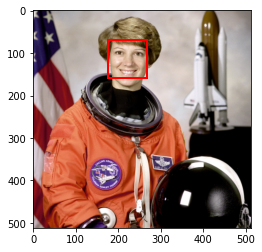

In [7]:
# code sample from https://scikit-image.org/docs/dev/auto_examples/applications/plot_face_detection.html

from skimage import data
from skimage.feature import Cascade

import matplotlib.pyplot as plt
from matplotlib import patches

# Load the trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the detector cascade.
detector = Cascade(trained_file)

img = data.astronaut()

detected = detector.detect_multi_scale(img=img,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(60, 60),
                                       max_size=(123, 123))

plt.imshow(img)
img_desc = plt.gca()
plt.set_cmap('gray')

for patch in detected:

    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill=False,
            color='r',
            linewidth=2
        )
    )

plt.show()

In [8]:
from skimage import data
from skimage.feature import Cascade

import matplotlib.pyplot as plt
from matplotlib import patches

# Load the trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the detector cascade.
detector = Cascade(trained_file)

def count_faces(image: np.array) -> int:
    detected = detector.detect_multi_scale(
        img=image,
        scale_factor=1.2,
        step_ratio=1,
        min_size=(60, 60),
        max_size=(123, 123)
    )
    return len(detected)

In [9]:
count_faces(skimage.data.astronaut())

1

## Задание 4

Теперь необходимо найденные лица выгрузить в виде *RGB*-изображения (*numpy*-массив), чтобы впоследствии затем передать их функции, которая сверит найденное лицо с фотографиями сотрудников в базе данных.

Используйте код из предыдущего задания и верните одно изображение найденного лица в виде *numpy*-массива (гарантируется, что входные данные будут такими, что лицо на картинке одно).

**Входные данные:** *RGB*-картинка `image` в виде *numpy*-массива.

**Результат:** реализуйте функцию `extract_face(image)`, которая вернёт найденное лицо в виде *RGB*-картинки (*numpy*-массив).

- **Sample input:** `extract_face(skimage.data.astronaut())`
- **Sample output:** *numpy*-массив с найденным лицом.

In [10]:
def extract_face(image: np.array) -> np.array:
    detected = detector.detect_multi_scale(
        img=image,
        scale_factor=1.2,
        step_ratio=1,
        min_size=(60, 60),
        max_size=(123, 123)
    )
    face = detected[0]
    r = face['r']
    c = face['c']
    return image[r:r+face['height'], c:c+face['width']]

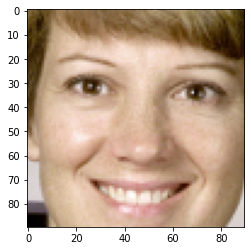

In [11]:
face = extract_face(skimage.data.astronaut())
plt.imshow(face)

## Задание 5

После оглушительного успеха в распознавании лиц к вам обратился потенциальный заказчик, который публикует фотографии улиц. В некоторых случаях на фотографиях запечатлены люди, и заказчик хочет скрыть их лица, чтобы избежать исков о нарушении частной жизни.

Раз уж вы уже умеете выделять лица, то вам не составит труда и наложить на них другую картинку.

**Входные данные:** *RGB*-картинка `image` в виде *numpy*-массива, *RGB*-картинка `patch`, которую надо наложить на найденные лица.

**Результат:** реализуйте функцию `patch_faces(image, patch)`, *RGB*-картинку `image` (*numpy*-массив), в которой во всех местах, где были лица, теперь располагается картинка `patch`, отмасштабированная соответствующим образом. Для масштабирования картинки `patch` используйте функцию
`skimage.transform.resize`:

```
p = (skimage.transform.resize(patch, (height, width)) * 255).astype(int)
```

- **Sample input:** `patch_faces(skimage.data.astronaut(), skimage.imread('smile.jpg'))`
- **Sample output:** *RGB*-картинка с астронавтом, на месте лица - смайлик.

In [12]:
def patch_faces(image: np.array, patch: np.array) -> np.array:
    detected = detector.detect_multi_scale(
        img=image,
        scale_factor=1.2,
        step_ratio=1,
        min_size=(60, 60),
        max_size=(123, 123)
    )
    for face in detected:
        r = face['r']
        c = face['c']
        height = face['height']
        width = face['width']
        p = (skimage.transform.resize(patch, (height, width)) * 255).astype(int)
        image[r:r+height, c:c+width] = p
    return image

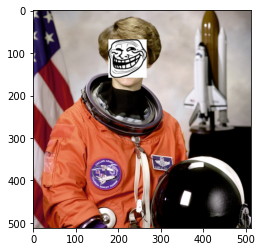

In [13]:
result = patch_faces(skimage.data.astronaut(), skimage.io.imread('data/smile.jpg'))
plt.imshow(result)